# 2019 NINTENDO SENTIMENT

## Auto Reload

In [1]:
%load_ext autoreload
%autoreload 2

## Import Relevant Libraries

In [2]:
import pandas as pd
import datetime
from datetime import timezone
import json
import numpy as np
from pandas.io.json import json_normalize
import string
import nltk
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from math import pi
import time 
import pickle
import os
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


from nintendo.nintendo_functions_2 import (   #for api use
    fetch_from_cache_or_api, 
    get_token, 
    get_tweets, 
    store_many_tweets, 
    store_response_tweets, 
    tweet_coll)

from nintendo.functions import (
    create_text2_without_hash_ats_links,
    remove_punctuation,
    make_lower_case,
    lemmatize_text,
    remove_stop_words,
    remove_just_links,
    vader_sentiment,
    trend_line_by_time,
    automated_radar_plots,
    trend_2019,
    radar_2019,
    )

## Fully Automated Functions

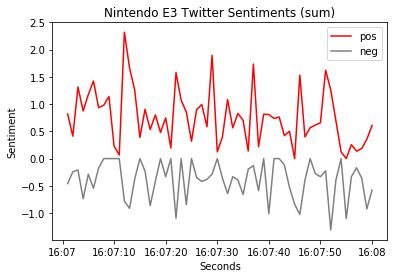

In [3]:
trend_2019(start_time='16:07:00', 
           end_time='16:08:00', 
           sum_mean='sum'
           )

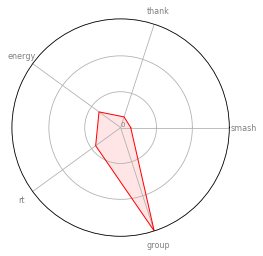

In [5]:
radar_2019(start_time='16:38:00', 
           end_time='16:42:00', 
           which_five='top'
           )

## Pulls 100 Tweets into Mongo DB (no repeats)

In [ ]:
#store_many_tweets(limit=20)

## Load Tweets from Mongo DB (store in DF)
#### IMPORTANT NOTE: 'tweet_coll' called MY pulled Twitter data... change this to call YOUR pulled Twitter data.

In [ ]:
tweet_coll.count_documents({})

In [ ]:
tweets = list(tweet_coll.find())

In [ ]:
df = json_normalize(tweets)

## DF Cleaning


In [ ]:
len(df)

Select relevant columns

In [ ]:
df = df[['user.id', 'text', 'lang', 'created_at']]

Filter for English only (also uses only relevant columns)  

In [ ]:
 df = df.loc[df['lang'] == 'en']

Add a .time. column showing H:M:S    

In [ ]:
#outputs str
df['.time.'] = df['created_at'].map(lambda x: x[11:19]) 

In [ ]:
#outputs datetime.time
df['datetime'] = df['.time.'].map(lambda x: datetime.datetime.strptime(x, "%H:%M:%S"))
df['datetime'] = df['datetime'].map(lambda x: x.time())

Remove any duplicate rows.

In [ ]:
df = df.drop_duplicates(subset=None, keep='first')

Sort df by time.

In [ ]:
df = df.sort_values(by='.time.')

## EDA

In [ ]:
len(df)

In [ ]:
df.info()

In [ ]:
df.isna().sum()

In [ ]:
print(df['.time.'].min())
print(df['.time.'].max())

## Text Cleaning

Remove any words starting with: #, @, or http and put cleaned text into new 'text2' column.

In [ ]:
create_text2_without_hash_ats_links(df)

Remove punctuation

In [ ]:
remove_punctuation(df)

Make lower case

In [ ]:
make_lower_case(df)

Lemmatize

In [ ]:
lemmatize_text(df)

Remove stop words

In [ ]:
remove_stop_words(df)

Remove links again (some links left over if they began with punctuation)

In [ ]:
remove_just_links(df)

Reset Index

In [ ]:
df = df.reset_index()

## Vader Sentiments

In [ ]:
vader_output = vader_sentiment(df)

In [ ]:
matrix_df = json_normalize(vader_output)

In [ ]:
df = pd.concat([df, matrix_df], axis=1)

## PICKLE DF

In [ ]:
# with open ('./nintendo/pkl/2019_df.pkl', 'wb') as f:
#     pickle.dump(df, f)

In [ ]:
with open ('./nintendo/pkl/2019_df.pkl', 'rb') as f:
    df = pickle.load(f)

## Trend Lines - With Time Selector

In [ ]:
trend_line_by_time(df, 
                   start_time_str='16:09:24', 
                   end_time_str='16:15:36',
                   sum_mean='sum')

## Radar Plots - With Time Selector

In [ ]:
automated_radar_plots(df, 
                           start_time='16:07:24', 
                           end_time='16:08:36', 
                           which_five='top')